In [272]:
import numpy as np
import pandas as pd
import scipy

# Объявление функций

In [273]:
def read_data(filepath: str, offset: int = 0, data_length: int = None, data_type: str ='int16') -> pd.DataFrame:
    """Фукнция для считывания данных из бинарных файлов

    Args:
        filepath (str): Путь до файла.
        offset (int, optional): Количество наблюдений, которое нужно пропустить сначала. Defaults to 0.
        data_length (int, optional): Необходимое количество наблюдений. Если не передавать никакого значения, будут считаны все данные, начиная с offset. Defaults to None.
        data_type (str, optional): Тип данных. Defaults to 'int16'.

    Returns:
        pd.DataFrame: Итоговая таблица. Столбцы right, top, left, bottom отвечают за данные с четырех пикапов.
    """

    # Считывание данных в один вектор
    line_data = np.fromfile(filepath, dtype=data_type)
    # Разделение вектора на четыре столбца матрицы, каждый из которых соответствует пикапу
    data = line_data.reshape(-1, 4)
    # Формирование датафрейма на основе предыдущей матрицы
    data = pd.DataFrame(data, columns=['right', 'top', 'left', 'bottom'])
    # Если не передано никакого значения в data_length, то будут браться все значение, начиная с offset
    if data_length is None: data_length = len(data) - offset
    # Из полученного датафрейма делается срез, начиная с offset, длинной data_length. в котором сбрасываются индесы (чтобы они начинались с нуля)
    data = data.iloc[offset: offset + data_length].reset_index().drop('index', axis=1)
    return data

In [274]:
def fft_with_corrected_frequences(data: np.ndarray, corrected_frequences: np.ndarray, number_of_samples: int = 256, number_of_values: int = None) -> np.ndarray:
    """Прямое преборазование Фурье с учетом корректировочных частот

    Args:
        data (np.ndarray): Вектор данных
        corrected_frequences (np.ndarray): Вектор корректировочных частот
        number_of_samples (int, optional): Число отсчетов для преобразования Фурье. Для корректной работы должно быть степенью двойки. Defaults to 256.
        number_of_values (int, optional): Число итоговых знячений. По умолчанию, выводятся все. Defaults to None.

    Returns:
        np.ndarray: Преобразованный вектор
    """

    # Преобразование данных в формат np.ndarray для корректной работы
    data = np.array(data)
    # Если number_of_values не был задан, берутся все значение
    if number_of_values is None: number_of_values = len(data)
    # Реализация прямого преобразования Фурье с корректировочными частотами (2j означает 2 * мнимую единицу)
    return np.fromiter((data[:number_of_samples] @
            np.exp(2j * np.pi * corrected_frequences[i] * np.arange(number_of_samples))
            for i in range(number_of_values)), 'complex')

In [275]:
def find_period(data: np.ndarray, number_of_samples: int = 32*2048, sample_length: int = 10, period_correction: float = 0.005,
                number_of_amplitudes_for_corrected_period: int = 20, half_window_length: int = 5) -> float:
    """Поиск периода в данных с помощью преобразования Фурье со сглаживанием и корректировочными частотами

    Args:
        data (np.ndarray): Вектор данных
        number_of_samples (int, optional): Число отсчетов для преобразования Фурье. Defaults to 32*2048.
        sample_length (int, optional): Длина окна, в котором выполняется сглаживание методом среднего. Defaults to 10.
        period_correction (float, optional): Изменение периода, относительно которого происходит корректировка. Defaults to 0.005.
        number_of_amplitudes_for_corrected_period (int, optional): Число амплитуд после второй корректировки. Defaults to 21.
        half_window_length (int, optional): Дляга полуокна, в котором будет производится регрессия. Defaults to 5.

    Returns:
        float: Значение периода
    """

    # Перевод данных в формат np.ndarray для корректной работы
    data = np.array(data)
    # Разделение данных на numer_of_samples участков по sample_length значений для последующего сглаживания
    sampled_data = data[:(number_of_samples * sample_length)].reshape(-1, sample_length)
    # Сглаживание данных на каждом из участков посредством усреднения
    smoothed_data = pd.DataFrame(sampled_data.T).mean().to_numpy()
    # Применение прямого преобразования Фурье для сглаженных данных. Нахождение амплитуд
    fourier_decomposition_amplitudes = np.abs(scipy.fft.fft(smoothed_data, norm='forward'))
    # Нахождение несущей частоты для полученных амплитуд
    carrier_frequency = np.argmax(fourier_decomposition_amplitudes)
    # Проверка на неравенство несущей частоты нулю
    if carrier_frequency == 0: raise ValueError("Incorrect_data. Carrier frequency can't be zero")
    # Нахождения периода в данных после сглаживания
    period_after_smoothing = number_of_samples * sample_length / carrier_frequency
    # Нахождение корректировочных периодов
    corrected_periods = period_after_smoothing * (1 + period_correction * (2*np.arange(number_of_amplitudes_for_corrected_period + 1)
                                                                           / number_of_amplitudes_for_corrected_period - 1)) # Уточненные периоды для каждого окна
    # Применение прямого преобразования Фурье к данным с учетом корректировочных периодов. Нахождение амплитуд
    fourier_decomposition_amplitudes_with_corrected_periods = 1 / (number_of_samples * sample_length) *\
        np.abs(fft_with_corrected_frequences(data, 1 / corrected_periods,
                                      number_of_samples*sample_length,
                                      number_of_amplitudes_for_corrected_period))
    # Нахождение несущей частоты  (или несущего периода) для полученных на предыдущем шаге амплитудах
    carrier_frequency_in_corrected_spectrum = np.argmax(fourier_decomposition_amplitudes_with_corrected_periods)
    # Нахождение значений отклонений от несущего периода. В данном случае, в обе стороны откладывается по half_window_length значений
    deviations_form_carrier_period_slice = corrected_periods[carrier_frequency_in_corrected_spectrum-half_window_length:
                                                             carrier_frequency_in_corrected_spectrum+half_window_length+1] -\
                                            carrier_frequency_in_corrected_spectrum
    # Аналогично, берется такое же окно для амплитуд.
    fourier_decomposition_amplitudes_with_corrected_periods_slice =\
        fourier_decomposition_amplitudes_with_corrected_periods[carrier_frequency_in_corrected_spectrum-half_window_length:
                                                                carrier_frequency_in_corrected_spectrum+half_window_length+1]
    # Построение квадратичной регрессии по отклонениям и амплитудам
    square_regressions_coefficients = np.polyfit(deviations_form_carrier_period_slice,
                                                fourier_decomposition_amplitudes_with_corrected_periods_slice, 2)
    # Нахождение итогового периода в данных
    data_period = carrier_frequency_in_corrected_spectrum - (square_regressions_coefficients[1]) / (2 * square_regressions_coefficients[0])

    return data_period

In [276]:
def get_beam_center_positions(summary_resonace: np.ndarray, difference_resonance: np.ndarray, period_length: float) -> np.ndarray:
    """Фукнция для вычисления координат центра масс по заданным суммарным и разностным резонансом для одной из осей.

    Args:
        summary_resonace (np.ndarray): Вектор суммарных резонансов по одной из осей.
        difference_resonance (np.ndarray): Вектор разностных резонансов по той же самой оси.
        period_length (float): Длина периода. Может быть дробной.

    Returns:
        np.ndarray: Вектор со значениями координаты центра масс для каждого из периодов по заданной оси.
    """

    # Вычисление общего количества периодов
    number_of_periods = int(len(summary_resonace) / period_length)
    # Задания вектора, с количеством элементов, равным числу периодов, для хранения полученных координат. Изначально заполнен нулями
    mass_center_positions = np.zeros(number_of_periods)
 
    # Запускаем цикл от 0 до number_of_periods-1 включительно с шагом 1. Грубо говоря, этим циклом мы пробегаемся по всем периодам
    for i in range(number_of_periods):

        # Находим срез, соответсвующий текущему периоду, для векторов summary_resonance и difference_resonance.
        # ВАЖНАЯ ДЕТАЛЬ. В данном случае, вручную задается тип int64, так как происходит переполнение изначального типа int16 при возведении значений в квадрат
        summary_resonance_period_slice = np.array(summary_resonace, 'int64')[int(i*period_length): int((i+1)*period_length)] 
        difference_resonance_period_slice = np.array(difference_resonance, 'int64')[int(i*period_length): int((i+1)*period_length)] 
 
        # Вычисление промежуточных параметров. Автор не особо осведомлен об их природе, поэтому тут могут потребоваться дополнительные пояснения
        m_11 = float(np.sum(summary_resonance_period_slice**2))
        m_12 = float(np.sum(summary_resonance_period_slice)) 
 
        y_1 = float(summary_resonance_period_slice @ difference_resonance_period_slice) 
        y_2 = float(np.sum(difference_resonance_period_slice)) 

        # Вычисление значения координаты центра масс для текущего периода. Добавление ее в итоговый вектор
        mass_center_positions[i] = ((m_12 * y_2) - (np.floor(period_length) * y_1)) / (m_12 ** 2 - m_11 * np.floor(period_length)) 
 
    return mass_center_positions

In [277]:
# WARNING!!! Данная функция пока еще не была протестирована для правой части спектра
def get_spectrum(beam_center_coordinates: np.ndarray, number_of_samples: int = 2**8, offset: int = 3, is_left_part: bool = True) -> tuple:
    """Функция для нахождения спектра дробной части бетатронной частоты.

    Args:
        beam_center_coordinates (np.ndarray): Вектор координат центров масс пучка по одной из осей.
        number_of_samples (int, optional): _description_. Число отсчетов для дискретного преобразования Фурье. Для корректной работы должно быть степенью двойки. Defaults to 2**8.
        offset (int, optional): _description_. Количество частот, которые мы пропускаем сначала (т.е. считаем их амплитуду нулевой). Defaults to 3.
        is_left_part (bool, optional): _description_. Флаг, отвечающий за интересующую часть спектра. Если True - берется левая часть спектра (частота меньше 0.5).
            Если False - правая (частота больше 0.5). Defaults to True.

    Returns:
        tuple: Возвращает кортеж с двумя векторами типов np.ndarray: frequences - значения частот, amplitudes - значения соответствующих им амплитуд.
    """

    # Применяем прямое преобразование Фурье для первый number_of_samples координат центров масс. Для получения нужной нормировки, делим на number_of_samples
    fourier_transformed_vector = scipy.fft.fft(np.array(beam_center_coordinates)[:number_of_samples]) / number_of_samples
    # Заполняем первые offset значений нулями и оставляем только первую половину значений от преобразованного вектора. В дальнейшем, если будет нужна правая часть, это преобразуется
    sliced_fourier_transformed_vector = np.concatenate([np.zeros(offset), fourier_transformed_vector[3: number_of_samples // 2]])
    # Находим амплитуды сигналов, находя абсолютные значения для каждой из величин преобразованного вектора
    amplitudes = np.abs(sliced_fourier_transformed_vector)

    # С помощью данного ветвления происходит выбор между правой и левой частями спектра
    if is_left_part:
        # Если левая часть спектра, то частоты берутся от 0 до 0.5
        frequences = np.arange(0, 0.5, 1 / number_of_samples)
    else:
        # WARNING!!! Данная часть не тестировалась. Возможные ошибки:
        # 1. Неправильный порядок частот или амплитуд. Можно попытаться отразить порядок следования элементов в массиве. Например, amplitudes = amplitudes[::-1].
        # 2. Небольшое смещение частот. Для этого, при расчете frequences нужно убрать слагаемое "+ 1 / number_of periods"

        # Если правая часть спектра, то сначала нужно преобразовать амплитуды
        amplitudes = 1 - amplitudes
        # Частоты берутся от 0.5 до 1
        frequences = np.arange(0.5, 1, 1 / number_of_samples) + 1 / number_of_samples

    return frequences, amplitudes

In [278]:
def find_main_frequence(frequences: np.ndarray, amplitudes: np.ndarray, slice_percentage: float = 0.5) -> float:
    """Функция для нахождения основной частоты спектра.

    Args:
        frequences (np.ndarray): Вектор частот спектра.
        amplitudes (np.ndarray): Вектор амплитуд спектра.
        slice_percentage (float, optional): Параметр, отвечающий за долю значений, которые будут расматриваться (автор не до конца в этом уверен)/
            По умолчанию, берутся все значения. Defaults to 0.5.

    Raises:
        ValueError: Возникает, если frequences и amplitudes имеют разную длину.

    Returns:
        float: Значение основной частоты
    """

    # Проверка на соответствие длин frequences и amplitudes. При несоответсвии выдается исключение
    if len(frequences) != len(amplitudes):
        raise ValueError('frequences and amplitudes must have same length')
    
    # Находим позицию, на которой находится значение максимальной из амплитуд вместе с соотвествующим срезом (умножение на двойку было в маткадовском коде,
    # если его убрать, то значение по умолчанию для slice_percentage нужно сделать равным единице).
    main_frequence_index = np.argmax(amplitudes[:int(slice_percentage * 2 * len(frequences))])
    # Выделяем частоту, которая находится на найденной выше позиции.
    main_frequence = frequences[main_frequence_index]
    return main_frequence

In [279]:
def damped_oscillations_fit(x_data: np.ndarray, y_data: np.ndarray, bounds: dict = None) -> tuple:
    """Подгоняет данные под функцию затухающих колебаний вида: A * exp(-beta * x) * cos(omega*x + phi) + bias

    Args:
        x_data (np.ndarray): Вектор данных для оси абцисс
        y_data (np.ndarray): Вектор данных для оси ординат
        bounds (dict, optional): Граничные условия для параметров. По умолчанию следующие:
                                    {'A': (0, np.inf), 'omega': (-np.inf, np.inf),
                                    'phi': (0, 2*np.pi), 'beta': (0, np.inf), 'bias': (-np.inf, np.inf)}.
                                 Для их задания нужно передать в функцию словарь такого же вида, где левое и правое значение
                                 в каждом из кортежей означают максимально и минимально возможные значение. Если какой-то параметр
                                 будет пропущен, он автоматически заменится значением по умолчанию. Для задания бесконечных границ
                                 следует использовать np.inf и -np.inf для +∞ и -∞ соответственно.Defaults to None.

    Returns:
        function: Итоговая фукнция, которая вызываетсяследующим образом: function(t)
        dict: Словарь со значениями параметров. Ключи: {'A', 'omega', 'phi', 'beta', 'bias'}
    """

    # Значения границ по умолчанию
    default_bounds = {'A': (0, np.inf), 'omega': (-np.inf, np.inf),
                    'phi': (0, 2*np.pi), 'beta': (0, np.inf), 'bias': (-np.inf, np.inf)}
    # Если параметр bounds в функцию не передавался, то он заменяется значением по умолчанию
    if bounds is None: bounds = default_bounds
    # Формирование пустого двухуровневого списка, размером 2 на 5, для формирования граничных условий в приемлемом для оптимизатора виде
    bounds_list = [[0]*5, [0]*5]
    # Цикл, в котором происходит заполнение списка
    for i, parameter_name in enumerate(('A', 'omega', 'phi', 'beta', 'bias')):
        # Если какой-то из параметров отсутсвует в словаре, он заменяется значением по умолчанию
        if parameter_name not in bounds: bounds[parameter_name] = default_bounds[parameter_name]
        # Заполнение списка граничными условиями
        bounds_list[0][i] = bounds[parameter_name][0]
        bounds_list[1][i] = bounds[parameter_name][1]
    # Функция гармонических колебаний с параметрами, нужная для последующего фитирования
    damped_oscillations_function = lambda t, A, omega, phi, beta, bias: A * np.exp(-beta*t) * np.cos(omega*t + phi) + bias
    # Проведение фитирования, извлечение параметров
    A, omega, phi, beta, bias = scipy.optimize.curve_fit(damped_oscillations_function, x_data, y_data, bounds=bounds_list)[0]
    # Формирование результирующей функции
    result_function = lambda t: A * np.exp(-beta*t) * np.cos(omega*t + phi) + bias
    # Формирование словаря с итоговыми параметрами
    parameters = {'A': A, 'omega': omega, 'phi': phi, 'beta': beta, 'bias': bias}
    return result_function, parameters

# Пример реализации кода

## Подключение библиотек для рисования графиков

In [280]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme() # Установка более красивой темы для графиков

## Задание стартовых переменных и загрузка данных

Параметры считывания данны: offset - количество пропускаемых сначала значений, len_data - количество необходимых значений. Следует понимать, что в данном случае все данные изначально делятся на 4 столбца и после этого считается количество строк, которые нужно пропустить и отобрать. Таким образом, эти величины должны быть в 4 раза меньше по сравнению с тем, если бы все отбиралась из изначального одномерного вектора, как это реализовано в маткаде.

In [281]:
offset = 8 * 6300 // 2 // 4
len_data = 4 * 1024**2 // 4

Формирования словаря, в котором хранятся размеры пластинки по каждой из осей

In [282]:
plate_size = {}
plate_size['X'] = 64
plate_size['Y'] = 33
plate_size

{'X': 64, 'Y': 33}

Задание пути, по которому хранятся исходные данные

In [283]:
filepath = r'bpm_data/11_01_booster_libera08_hbpm3_1_full'

Загрузка данных

In [284]:
data = read_data(filepath, offset=offset, data_length=len_data)
data

,right,top,left,bottom
0,-147,-273,-406,79
1,-157,-196,-416,321
2,17,-124,-416,383
3,373,-29,-415,230
4,247,-82,-421,-149
...,...,...,...,...
1048571,496,365,32,438
1048572,526,141,228,682
1048573,614,271,132,356
1048574,486,376,130,-11


## Нахождение координат центров масс

Вычисление суммарных и разностных резонансов для каждой из осей

In [285]:
summary_resonance = pd.DataFrame()
summary_resonance['X'] = data['right'] + data['left']
summary_resonance['Y'] = data['top'] + data['bottom']

difference_resonance = pd.DataFrame()
difference_resonance['X'] = data['right'] - data['left']
difference_resonance['Y'] = data['top'] - data['bottom']

Нахождение периода. В данном случае, для суммарных резонансов по оси Ox

In [286]:
period = find_period(summary_resonance['X'])
period

2128.751497045826

Нахождение координат центров масс пучка для каждого из периодов по каждой из осей

In [287]:
beam_center_coords = pd.DataFrame()
for axis in ['X', 'Y']:
    beam_center_coords[axis] = plate_size[axis] * get_beam_center_positions(summary_resonance[axis], difference_resonance[axis], period)
beam_center_coords

,X,Y
0,1.303567,1.448332
1,-0.643356,1.535053
2,-2.574663,-0.158554
3,-4.874315,-1.920665
4,-4.766045,-2.940025
...,...,...
487,2.466626,1.702055
488,-3.553345,-0.141895
489,-1.755157,0.474462
490,1.770417,-0.924300


Построение гистограммы распределений координат центров масс

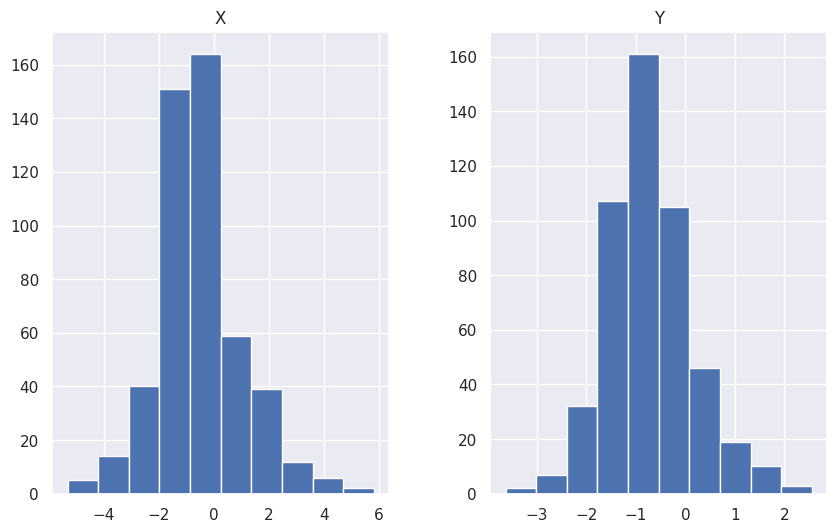

In [288]:
beam_center_coords.hist(figsize = (10, 6));

## Хроматичность

Нахождение спектра и основных часот для каждой из осей

In [289]:
spectrum = pd.DataFrame()
main_frequences = {}

for axis in 'X', 'Y':
    freq, amp = get_spectrum(beam_center_coords[axis])
    spectrum[axis + ' amplitudes'] = amp
    main_frequences[axis] = find_main_frequence(freq, amp)

spectrum['frequences'] = freq
spectrum = spectrum.set_index('frequences')
spectrum

,X amplitudes,Y amplitudes
frequences,,
0.000000,0.000000,0.000000
0.003906,0.000000,0.000000
0.007812,0.000000,0.000000
0.011719,0.015387,0.025286
0.015625,0.036173,0.017706
...,...,...
0.480469,0.051900,0.025764
0.484375,0.010558,0.024299
0.488281,0.059366,0.007955


Построение графиков спектров с указанием на них основных частот

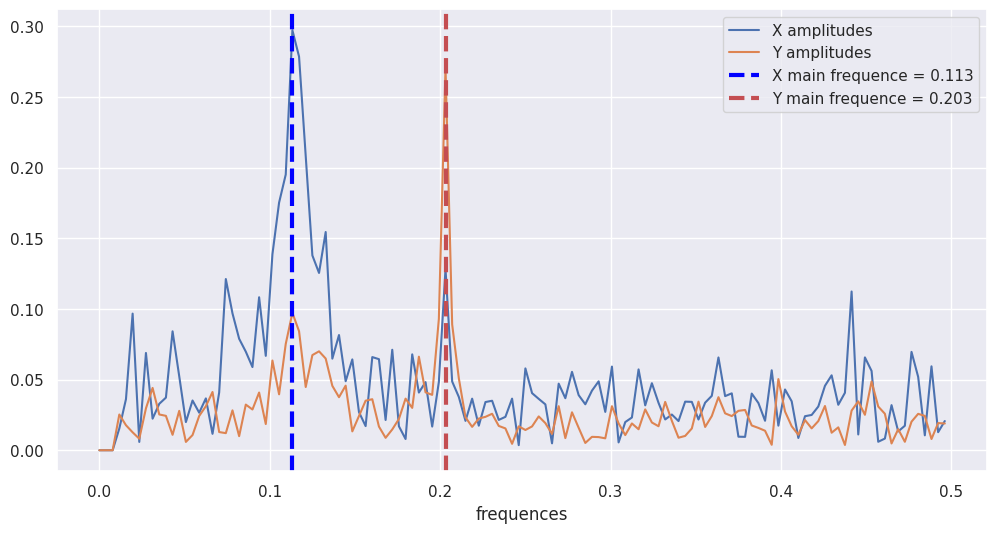

In [290]:
spectrum.plot(figsize=(12, 6))
plt.axvline(main_frequences['X'], ls='--', c='blue', lw=3, label=f'X main frequence = {round(main_frequences["X"], 3)}')
plt.axvline(main_frequences['Y'], ls='--', c='r', lw=3, label=f'Y main frequence = {round(main_frequences["Y"], 3)}')
plt.legend();

Будем аппроксимировать координаты центров масс функцией затухающих колебаний вида
$$y = Ae^{-\beta t}cos(\omega x + \varphi) + b$$
Смещение нужно по той причине, что детекторы могут быть не до конца откалиброваны

Изобразим на графике положения цетров масс для каждой из осей

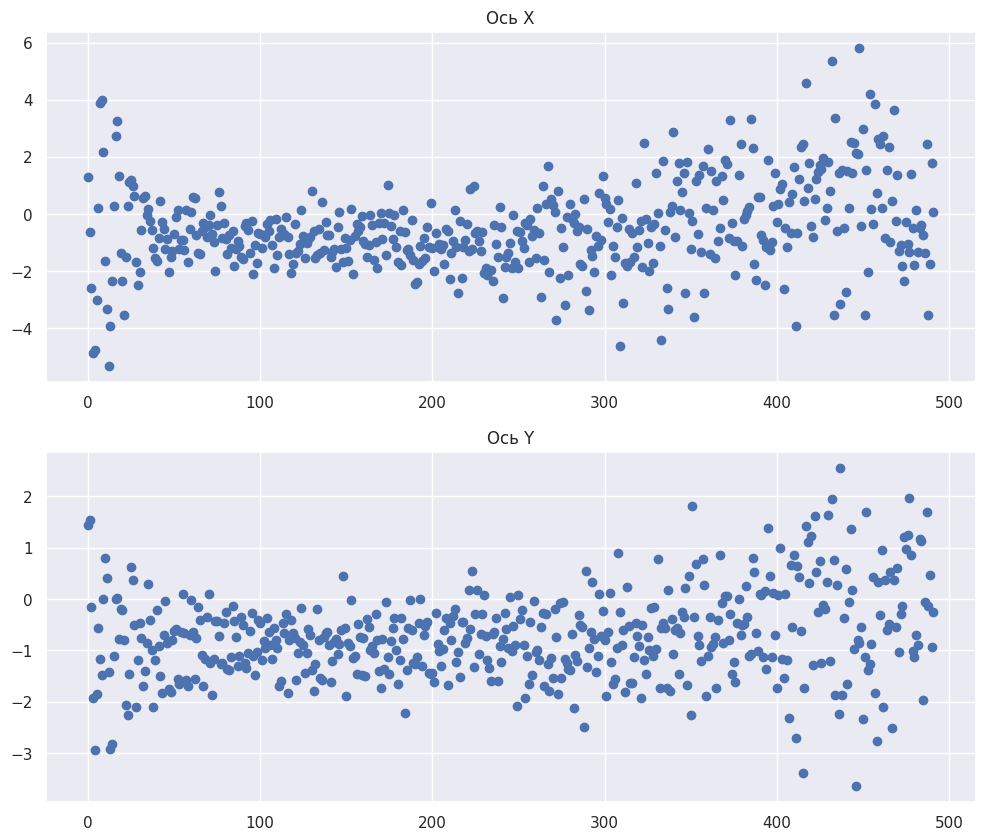

In [291]:
t = np.arange(492)
fig, axs = plt.subplots(2, figsize=(12, 10))
axs[0].scatter(t, beam_center_coords['X'])
axs[0].set_title('Ось X')
axs[1].scatter(t, beam_center_coords['Y'])
axs[1].set_title('Ось Y');

В данном случае видно,что затухающие колебания оканчиваются примерно на 100-ом значении для каждой из осей. Зададим словарь, в который введем значения срезов

In [292]:
slice_length = {'X': 100, 'Y': 100}

Зададим граничные условия для нашей функции. В данном случае, для частоты сделаем допустимым отклонение в 0.01 от основной. Также, искуственно ограничим амплитуды и коэффициент затухания для оси Y. Эти значения были подогнаны экспериментально после нескольких попыток

In [330]:
bounds = {
    'X': {'omega': (2*np.pi*main_frequences['X'] - 0.01, 2*np.pi*main_frequences['X'] + 0.01),
              'A': (2, np.inf)},

    'Y': {'omega': (2*np.pi*main_frequences['Y'] - 0.01, 2*np.pi*main_frequences['Y'] + 0.01),
              'A': (2.2, 4),
           'beta': (0, .02)}
}

Найдем сами аппроксимирующие функции

In [331]:
function = {}
cromacity = {}

for axis in 'XY':
    t = np.arange(slice_length[axis]) #Массив t задаем в соответсвии с заданным выше срезом
    function[axis], parameters  = damped_oscillations_fit(t, beam_center_coords[axis][t], bounds=bounds[axis])
    chromacity[axis] = parameters['A']

    print(f'''Параметры для {axis}:
          A = {parameters['A']}
          v = {parameters['omega'] / (2 * np.pi)} (theoretical = {main_frequences[axis]})
          phi = {parameters['phi']}
          beta = {parameters['beta']}
          bias = {parameters['bias']}''')

Параметры для X:
          A = 5.44574787522552
          v = 0.11417531842838853 (theoretical = 0.11328125)
          phi = 0.743825385556685
          beta = 0.03806358949456314
          bias = -0.7163105423627149
Параметры для Y:
          A = 2.2000000000000006
          v = 0.2034499763353197 (theoretical = 0.203125)
          phi = 5.150373082481694
          beta = 0.019999999999999997
          bias = -0.8987095206303517


Итоговые графики для каждой из функций

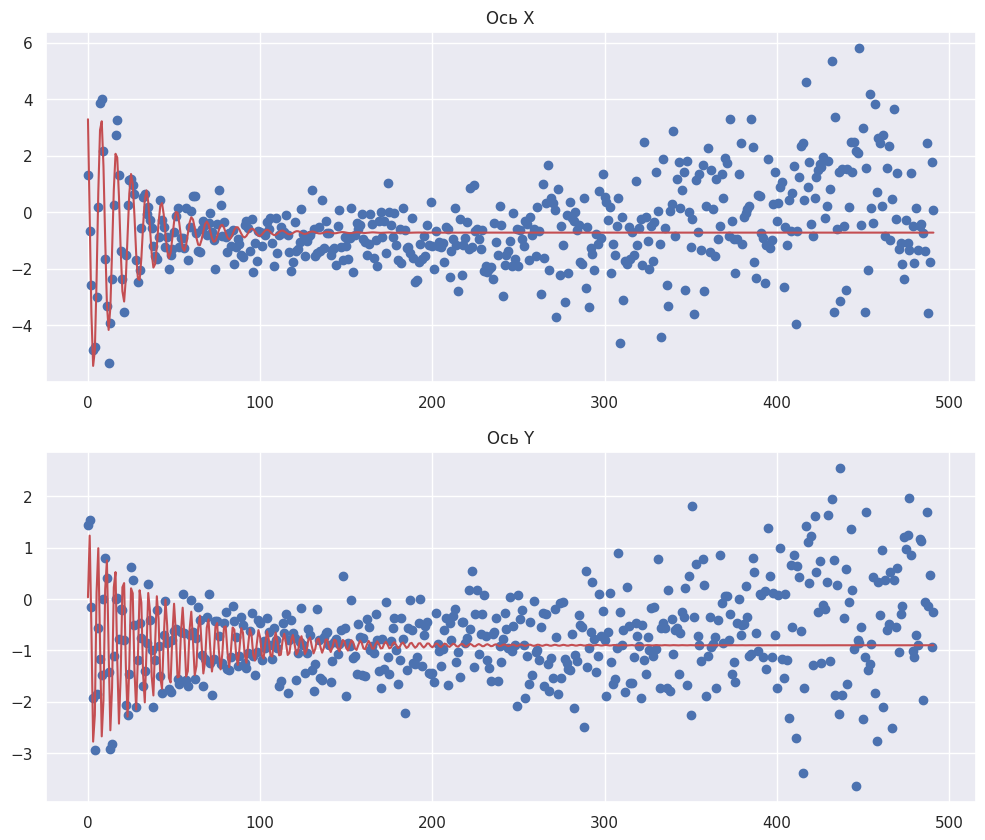

In [337]:
t = np.arange(492)
theoretical_values = pd.DataFrame()
for axis in 'XY':
    theoretical_values[axis] = function[axis](t)

fig, axs = plt.subplots(2, figsize=(12, 10))
axs[0].scatter(t, beam_center_coords['X'], label='Экспериментальные данные')
axs[0].plot(t, theoretical_values['X'], label='Кривая аппроксимации', color='r')
axs[0].set_title('Ось X')

axs[1].scatter(t, beam_center_coords['Y'])
axs[1].plot(t, theoretical_values['Y'], color='r')
axs[1].set_title('Ось Y');

Че вообще тут дальше происходит?

In [296]:
chi_x = 5.5 #Берем из амплитуд переобозначить xi. Или хроматичность
chi_y = 2.2
delta_p = 2.5 * 10**(-3) #Отклонения импульсов dp/p0. Отношение приращения к равновесному импульсу. Берется из теоретической настройки

In [339]:
chromacity = {'X': 5.5, 'Y': 2.2}
delta_impulse = 2.5e-3

In [417]:
def pseudo_gaussian_exponent_approximation(chromacity, delta_impulse, approximation_range, epsilon=0.01, sigma_max=np.inf):
    multiplier = 2 * np.pi * chromacity * delta_impulse
    initial_function = lambda x: np.sin(multiplier * x) / (multiplier * x)
    target_function = lambda x, sigma: np.exp(-x**2 / (2*sigma**2))

    x = np.arange(0.01, approximation_range, epsilon)
    y = initial_function(x)
    
    sigma = scipy.optimize.curve_fit(target_function, x, y, bounds=(0, sigma_max))[0][0]

    result_function = lambda x: np.exp(-x**2 / (2*sigma**2))
    
    return result_function, initial_function, sigma

In [418]:
result_function, initial_function, sigma = pseudo_gaussian_exponent_approximation(chromacity['X'], delta_impulse, 70)

In [419]:
result_function(t)

array([9.99999821e-01, 9.96001952e-01, 9.84208838e-01, 9.64897398e-01,
       9.38516286e-01, 9.05668567e-01, 8.67088808e-01, 8.23615800e-01,
       7.76162331e-01, 7.25683515e-01, 6.73145206e-01, 6.19493938e-01,
       5.65629651e-01, 5.12382252e-01, 4.60492744e-01, 4.10599399e-01,
       3.63229096e-01, 3.18793718e-01, 2.77591193e-01, 2.39810622e-01,
       2.05540756e-01, 1.74781028e-01, 1.47454297e-01, 1.23420522e-01,
       1.02490622e-01, 8.44398943e-02, 6.90204900e-02, 5.59725636e-02,
       4.50338589e-02, 3.59476024e-02, 2.84686912e-02, 2.23682432e-02,
       1.74366502e-02, 1.34853132e-02, 1.03472709e-02, 7.87693770e-03,
       5.94916211e-03, 4.45780431e-03, 3.31400378e-03, 2.44428477e-03,
       1.78861723e-03, 1.29852352e-03, 9.35295907e-04, 6.68367081e-04,
       4.73857624e-04, 3.33309351e-04, 2.32602258e-04, 1.61044967e-04,
       1.10623449e-04, 7.53900502e-05])

In [420]:
sigma

16.691075903607214

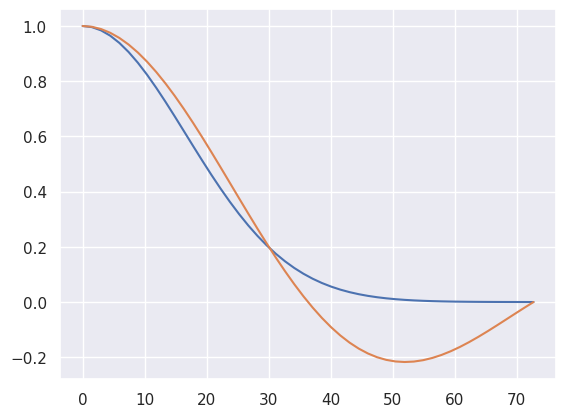

In [416]:
t = np.linspace(0.01, period)
plt.plot(t, result_function(t))
plt.plot(t, initial_function(t))

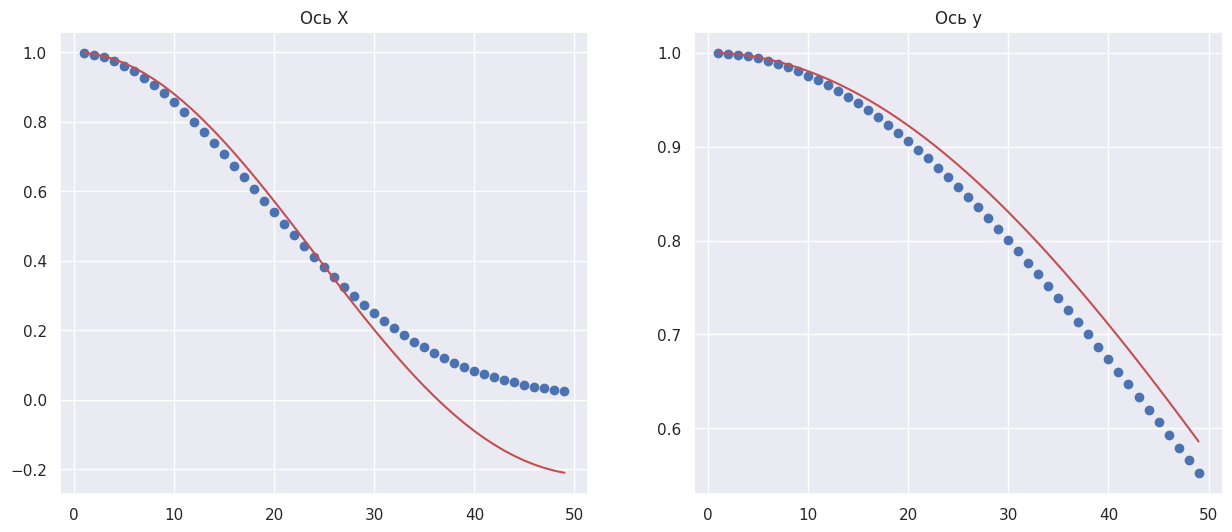

In [334]:
t = np.arange(1, 50) #Сводим на четверти периода синуса. Мб немного с хвостиком

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].scatter(t, np.exp(-t**2 / (2 * 18**2)))
axs[0].plot(t, find_AX(t, chi_x), color='r')
axs[0].set_title('Ось X')
# Экспонента затухающий колебаний. Коэффициент подгоняем 
axs[1].scatter(t, np.exp(-t**2 / (2 * 45**2)))
axs[1].plot(t, find_AX(t, chi_y), color='r')
axs[1].set_title('Ось y');

## Спектр суммарного сигнала

In [421]:
help(get_spectrum)

Help on function get_spectrum in module __main__:

get_spectrum(beam_center_coordinates: numpy.ndarray, number_of_samples: int = 256, offset: int = 3, is_left_part: bool = True) -> tuple
    Функция для нахождения спектра дробной части бетатронной частоты.
    
    Args:
        beam_center_coordinates (np.ndarray): Вектор координат центров масс пучка по одной из осей.
        number_of_samples (int, optional): _description_. Число отсчетов для дискретного преобразования Фурье. Для корректной работы должно быть степенью двойки. Defaults to 2**8.
        offset (int, optional): _description_. Количество частот, которые мы пропускаем сначала (т.е. считаем их амплитуду нулевой). Defaults to 3.
        is_left_part (bool, optional): _description_. Флаг, отвечающий за интересующую часть спектра. Если True - берется левая часть спектра (частота меньше 0.5).
            Если False - правая (частота больше 0.5). Defaults to True.
    
    Returns:
        tuple: Возвращает кортеж с двумя векто

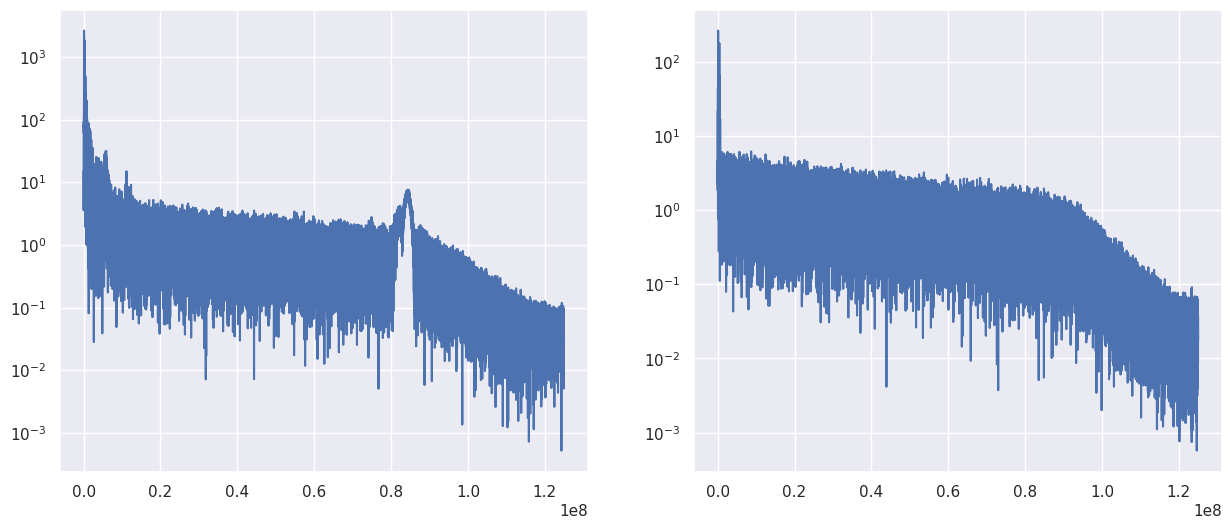

In [336]:
offset = 0
number_of_samples = 128 * 1024
data_length = len(data)
delta_t = (250 * 10**6)**(-1)

# Спектр первого окна. Амплитуды
s_p1 = np.abs(scipy.fft.fft(
    summary_resonance['X'][offset: number_of_samples+offset] +\
    summary_resonance['Y'][offset: number_of_samples+offset],
    norm='forward'))

# Спектр последнего окна
s_p2 = np.abs(scipy.fft.fft(
    summary_resonance['X'][data_length-number_of_samples:] +\
    summary_resonance['Y'][data_length-number_of_samples:],
    norm='forward'))

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
t = np.linspace(0, number_of_samples//2 / (number_of_samples * delta_t), number_of_samples//2)

#Графики амлитудных спектров сигнала
axs[0].plot(t, s_p1[:number_of_samples // 2])
axs[0].set_yscale('log')

axs[1].plot(t, s_p2[:number_of_samples // 2])
axs[1].set_yscale('log')